# Semi Direct Effects: Profiles for East and West

This notebooks is based on flux data derived from "pure" RESTART files. The standard output is too coarse (1 x 1 km2) to make robust flux estimates.

The following script was used to retrieve data from archive and make flux calculations:

```
> cat /work/bm0834/b380352/data/icon-lem/tools/run_flux_data_retrieval_and_calculations.sh
#!/bin/bash
#SBATCH --partition=prepost
#SBATCH --account=bb1174
#SBATCH --nodes=1
#SBATCH --mem=30GB
#SBATCH --time=04:00:00

set -x
set -e

# filename input
# ==============
input_filename=$*

basename=`basename ${input_filename}`
dirname=`dirname ${input_filename}`
variables_filename=variables_${basename}


# set directories
# ================
tools_dir="${HOME}/data/icon-lem/tools"
tmpdir="${HOME}/scratch/icon-lem/${dirname}"


# goto temporary dir
# =================
mkdir -p ${tmpdir}
cd ${tmpdir}


if [ ! -f ${variables_filename} ]; then
  # retrieve data from archive
  # ==========================
  tools_dir="${HOME}/data/icon-lem/tools"
  ${tools_dir}/retrieve_restart_file.sh ${input_filename}
  
  
  # extract only import variables
  # =============================
  varlist=w.TL1,theta_v.TL1,qv.TL1,qc.TL1,rho.TL1
  cdo select,name=${varlist} ${basename} ${variables_filename}
fi


# calculate fluxes
# ================
${tools_dir}/flux-script.py ${variables_filename}


rm ${basename}
```

## Libs

In [1]:
%matplotlib inline

import os, sys, glob
import pylab as plt
import numpy as np
import datetime

import seaborn as sns
sns.set_context('talk')

import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%H')

import xarray as xr
xr.set_options(keep_attrs=True)

import nawdex_analysis.io.tools


In [2]:
sys.path.append( '../tools' )

from input_regrid5km import map_level_and_halflevel_in_icondata


## Data Input

### Grid Area

In [3]:
fdir = '/pf/b/b380352/data/icon-lem/20130502_CCN_rad/GRID'
fname = f'{fdir}/grid_area_DOM01_regrid5km.nc'

aset = xr.open_dataset( fname )
area = aset['cell_area']

aweight = (area / area.mean()).compute()

### Variables

In [4]:


def input_restart( dom ):
    varlist = ['qv.TL1', 'theta_v.TL1', 'qc.TL1', 'w.TL1', 'rho.TL1', 'exner.TL1']
    
    if dom == 'DOM02':
        filepart = 'hdcp2_cosmodom_nest_R0312m'
    elif dom == 'DOM01':
        filepart = 'hdcp2_cosmodom_R0625m'
    
    print(dom)
    
    dlist = []

    fdir = '/pf/b/b380352/data/icon-lem/20130502_semi_direct_effect/RESTART'
    filename = f'{fdir}/{filepart}_restart_atm_20130502T??0000Z_subset_regrid5km.nc'
    flist = sorted( glob.glob( filename ) )[7:14]

    d5km = xr.open_mfdataset( flist )[varlist]
    d5km = d5km.expand_dims( 'mode' )

    d5km['mode'] = ['scattering', ]

    dlist += [d5km.copy(), ]


    fdir = '/pf/b/b380352/data/icon-lem/20130502_CCN_rad/RESTART'
    filename = f'{fdir}/{filepart}_restart_atm_20130502T??0000Z_subset_regrid5km.nc'
    flist = sorted( glob.glob( filename ) )[7:14]

    d5km = xr.open_mfdataset( flist )[varlist]
    d5km = d5km.expand_dims( 'mode' )

    d5km['mode'] = ['absorbing', ]
    dlist += [d5km.copy(), ]


    d5km = xr.concat(dlist, dim = 'mode')
    d5km = map_level_and_halflevel_in_icondata( d5km, full_lev_name = 'lev', half_lev_name = 'lev_2')

    d5km = d5km.expand_dims( 'dom' )
    d5km['dom'] = [dom, ]
    
    return d5km

In [5]:
d5km1 = input_restart( 'DOM01')
d5km2 = input_restart( 'DOM02')

d5km = xr.concat( [d5km1, d5km2], dim = 'dom')

DOM01


/pf/b/b380352/.conda/python37/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

/pf/b/b380352/.conda/python37/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,
/pf/b/b380352/.conda/python37/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: In x

DOM02


/pf/b/b380352/.conda/python37/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

/pf/b/b380352/.conda/python37/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,
/pf/b/b380352/.conda/python37/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: In x

In [6]:
d5km

<xarray.Dataset>
Dimensions:      (dom: 2, full_level: 150, half_level: 151, lat: 155, lon: 139, mode: 2, time: 7)
Coordinates:
  * full_level   (full_level) float64 1.0 2.0 3.0 4.0 ... 148.0 149.0 150.0
  * time         (time) float64 2.013e+07 2.013e+07 ... 2.013e+07 2.013e+07
  * lon          (lon) float64 4.5 4.572 4.643 4.715 ... 14.15 14.22 14.3 14.37
  * half_level   (half_level) float64 0.5 1.5 2.5 3.5 ... 148.5 149.5 150.5
  * mode         (mode) object 'scattering' 'absorbing'
  * lat          (lat) float64 47.5 47.54 47.59 47.63 ... 54.32 54.37 54.41
  * dom          (dom) object 'DOM01' 'DOM02'
Data variables:
    qv.TL1       (dom, mode, time, full_level, lat, lon) float64 dask.array<chunksize=(1, 1, 1, 150, 155, 139), meta=np.ndarray>
    theta_v.TL1  (dom, mode, time, full_level, lat, lon) float64 dask.array<chunksize=(1, 1, 1, 150, 155, 139), meta=np.ndarray>
    qc.TL1       (dom, mode, time, full_level, lat, lon) float64 dask.array<chunksize=(1, 1, 1, 150, 155, 139), meta=np.ndarray>
    w.TL1        (dom, mode, time, half_level, lat, lon) float64 dask.array<chunksize=(1, 1, 1, 151, 155, 139), meta=np.ndarray>
    rho.TL1      (dom, mode, time, full_level, lat, lon) float64 dask.array<chunksize=(1, 1, 1, 150, 155, 139), meta=np.ndarray>
    exner.TL1    (dom, mode, time, full_level, lat, lon) float64 dask.array<chunksize=(1, 1, 1, 150, 155, 139), meta=np.ndarray>
Attributes:
    CDI:                            Climate Data Interface version 1.9.8 (htt...
    history:                        Mon Mar 16 10:01:54 2020: cdo -remapcon,/...
    source:                         git@git.mpimet.mpg.de:icon-lem.git@f820c6...
    institution:                    Max Planck Institute for Meteorology
    Conventions:                    CF-1.4
    nml_time_nml:                   &TIME_NML\n CALENDAR=-1, INI_DATETIME_STR...
    nml_parallel_nml:               &PARALLEL_NML\n N_GHOST_ROWS=1, DIVISION_...
    nml_run_nml:                    &RUN_NML\n LTESTCASE=F, LDYNAMICS=T, IFOR...
    nml_io_nml:                     &IO_NML\n LKEEP_IN_SYNC=T, DT_DIAG=86400....
    nml_meteogram_output_nml:       &METEOGRAM_OUTPUT_NML\n LMETEOGRAM_ENABLE...
    nml_synsat_nml:                 &SYNSAT_NML\n LSYNSAT=F, F, F, F, F, F, F...
    nml_gridref_nml:                &GRIDREF_NML\n RBF_VEC_KERN_GRF_E=1, RBF_...
    nml_interpol_nml:               &INTERPOL_NML\n LLSQ_LIN_CONSV=F, LLSQ_HI...
    nml_sleve_nml:                  &SLEVE_NML\n MIN_LAY_THCKN=20.00000000000...
    nml_dynamics_nml:               &DYNAMICS_NML\n IEQUATIONS=3, IDIV_METHOD...
    nml_ha_dyn_nml:                 &HA_DYN_NML\n ITIME_SCHEME=14, ILEAPFROG_...
    nml_nonhydrostatic_nml:         &NONHYDROSTATIC_NML\n ITIME_SCHEME=4, NDY...
    nml_diffusion_nml:              &DIFFUSION_NML\n HDIFF_ORDER=5, K2_KLEV_M...
    nml_transport_nml:              &TRANSPORT_NML\n IHADV_TRACER=2, 2, 2, 2,...
    nml_echam_phy_nml:              &ECHAM_PHY_NML\n IDCPHYCPL=1, LDRYMOIST=T...
    nml_nwp_phy_nml:                &NWP_PHY_NML\n INWP_CONVECTION=0, 0, 0, 0...
    nml_nwp_tuning_nml:             &NWP_TUNING_NML\n TUNE_GKWAKE=1.500000000...
    nml_ensemble_pert_nml:          &ENSEMBLE_PERT_NML\n USE_ENSEMBLE_PERT=F,...
    nml_radiation_nml:              &RADIATION_NML\n LDIUR=T, NMONTH=0, LYR_P...
    nml_vdiff_nml:                  &VDIFF_NML\n LSFC_MOM_FLUX=T, LSFC_HEAT_F...
    nml_turbdiff_nml:               &TURBDIFF_NML\n ITYPE_SHER=0, IMODE_SHSHE...
    nml_echam_conv_nml:             &ECHAM_CONV_NML\n LMFMID=T, LMFPEN=T, LMF...
    nml_echam_cloud_nml:            &ECHAM_CLOUD_NML\n CTHOMI=238.14999999999...
    nml_gw_hines_nml:               &GW_HINES_NML\n LHEATCAL=F, RMSCON=0.8699...
    nml_lnd_nml:                    &LND_NML\n NLEV_SNOW=2, NTILES=1, FRLND_T...
    nml_sea_ice_nml:                &SEA_ICE_NML\n KICE=1, I_ICE_THERM=1, I_I...
    nml_art_nml:                    &ART_NML\n CART_INPUT_FOLDER=' ', LART_CH...
    nml_les_nml:                    &L

### Read High-Res Fluxes 

In [7]:


def input_fluxes( dom ):

    
    if dom == 'DOM02':
        filepart = 'hdcp2_cosmodom_nest_R0312m'
    elif dom == 'DOM01':
        filepart = 'hdcp2_cosmodom_R0625m'
    
    print(dom)
    
    dlist = []

    fdir = '/pf/b/b380352/data/icon-lem/20130502_semi_direct_effect/fluxes'
    filename = f'{fdir}/fluxes_{filepart}_restart_atm_20130502T??0000Z_regrid5km.nc'
    print( filename )
    flist = sorted( glob.glob( filename ) )

    d5km = xr.open_mfdataset( flist )
    d5km = d5km.expand_dims( 'mode' )

    d5km['mode'] = ['scattering', ]

    dlist += [d5km.copy(), ]


    fdir = '/pf/b/b380352/data/icon-lem/20130502_CCN_rad/fluxes'
    filename = f'{fdir}/fluxes_{filepart}_restart_atm_20130502T??0000Z_regrid5km.nc'
    flist = sorted( glob.glob( filename ) )

    d5km = xr.open_mfdataset( flist )
    d5km = d5km.expand_dims( 'mode' )

    d5km['mode'] = ['absorbing', ]
    dlist += [d5km.copy(), ]


    d5km = xr.concat(dlist, dim = 'mode')
    # d5km = map_level_and_halflevel_in_icondata( d5km, full_lev_name = 'lev', half_lev_name = 'lev_2')

    d5km = d5km.expand_dims( 'dom' )
    d5km['dom'] = [dom, ]
    
    return d5km

In [8]:
flux_hres1 = input_fluxes( 'DOM01' )
flux_hres2 = input_fluxes( 'DOM02' )

flux_hres = xr.concat( [flux_hres1, flux_hres2], dim = 'dom')


DOM01
/pf/b/b380352/data/icon-lem/20130502_semi_direct_effect/fluxes/fluxes_hdcp2_cosmodom_R0625m_restart_atm_20130502T??0000Z_regrid5km.nc


/pf/b/b380352/.conda/python37/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

/pf/b/b380352/.conda/python37/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,
/pf/b/b380352/.conda/python37/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: In x

DOM02
/pf/b/b380352/data/icon-lem/20130502_semi_direct_effect/fluxes/fluxes_hdcp2_cosmodom_nest_R0312m_restart_atm_20130502T??0000Z_regrid5km.nc


/pf/b/b380352/.conda/python37/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

/pf/b/b380352/.conda/python37/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,
/pf/b/b380352/.conda/python37/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: In x

## Analysis

### Calculate Pressure (needed as vertical coordinate)

In [9]:
def calc_pres( d_restart ):
    p00 = 1000e2
    Rd = 287
    cp=1004.
    d_restart['pres'] = p00 * ( d_restart['exner.TL1'] )**(cp/Rd)

In [10]:
calc_pres( d5km )
flux_hres['pres'] = d5km['pres']

### Temporal Averaging 

In [11]:
d5km = d5km.mean('time').load()
flux = flux_hres.mean('time').load()

/pf/b/b380352/.conda/python37/lib/python3.7/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


### Spatial Averaging: Define East  & West Subdomains

We use area-weighted mean.

In [12]:
def east_west_split( d5km, lon_mid = 10 ):
    west = d5km.lon < lon_mid
    east = d5km.lon > lon_mid

    dw = d5km * aweight


    dlist = []

    
    d = dw.where(east).mean(('lon', 'lat'))
    d = d.expand_dims('region')
    d['region'] = ['east']
    dlist += [d.copy() ]

    d = dw.where(west).mean(('lon', 'lat'))
    d = d.expand_dims('region')
    d['region'] = ['west']
    dlist += [d.copy() ]


    d = xr.concat( dlist, dim = 'region')

    return d


In [13]:
d = east_west_split( d5km )
f = east_west_split( flux )


## Plots

In [14]:
def plot_profile( dset, vname, method = 'diff', ax = None, scale = 1., plot_liquid_layer = True, 
                  lw = 3, ls = '-', color = 'C1', rcolor = 'black', alpha = 1., label = None):
    
    if ax is None:
        fig = plt.figure( figsize = (5,6))
        plt.subplots_adjust( bottom = 0.2, right = 0.7, left = 0.3, top = 0.85)
    else:
        plt.sca( ax )

    v = dset[vname].squeeze()
#    v = dset[vname].mean('time').squeeze()
                        
    if 'pressure' in dset:
        height = dset.pressure / 1e2
    else:
        # height = dset.sel(mode = 'scattering', )['pres'].mean('time') / 1e2
        height = dset.sel(mode = 'scattering', )['pres'] / 1e2
    
    
    if method == 'diff':
        diff =  v.sel(mode = 'absorbing') - v.sel(mode = 'scattering')
        
        d = scale * diff

        
        if 'dom' in d.dims:
            plt.fill_betweenx(height.mean('dom'), d.sel(dom = 'DOM01'), d.sel(dom = 'DOM02'),
                              color = color, alpha = alpha )
        else:
            plt.plot(d, height, lw = lw, color = color, alpha = alpha, label = label)
    
        plt.axvline(0, color = 'gray', alpha = 0.3, lw = 5)
        
    elif method == 'ref':
        d = scale * v.sel( mode = 'scattering' )
        
        if 'dom' in d.dims:
            plt.fill_betweenx(height.mean('dom'), d.sel(dom = 'DOM01'), d.sel(dom = 'DOM02'),
                              color = color, alpha = alpha )
        else:
            plt.plot(d, height, c = rcolor, lw = lw, ls = ls, label = label )

        #d = scale * v.sel( mode = 'absorbing' )
        #plt.plot(d, height, c = rcolor, lw = 1)

    elif method == 'rel':
        
        ref = v.sel( mode = 'scattering' )
        diff =  v.sel(mode = 'absorbing') - v.sel(mode = 'scattering')
        
        d = 100 * diff / ref
        plt.plot(d, height, lw = lw,  color = color)
        
    # plt.title('%s / ( %s )' % (d.long_name, d.units), pad = 20)
    
    if plot_liquid_layer:
        # include the liquid layer here, copied from notebook 05-Average-TD-profiles and hard-coded...
        h1, h2 = 778.1495972842262, 931.0229864211309
        plt.axhspan(h1, h2, color='darkturquoise', alpha=0.02)        
        
    plt.ylabel('Pressure / hPa')
    plt.ylim(1000, 200)
    
    return d
    

## Flux Comparison

In [15]:
def plot_flux_ref_comparision(f, df, vname, xlabel1, xlabel2, title, scale, 
                              ascale_factor = 1, legend_position = (0.3, 0.5),
                              xticks =[0,], plot_legend = False):
    
    col1 = 'lightgray'
    col2 = 'darkgray'
    
    col1 = 'yellowgreen'
    col2 = 'darkgreen'
    alpha = 0.6
    
    fac = 1.1
    fig, axs = plt.subplots( nrows = 1, ncols = 2, figsize = (fac * 5.5, fac * 8))
    plt.subplots_adjust( wspace = 0.15, top = 0.85, left = 0.2, bottom = 0.2, right = 0.8)
    a = axs[0]
    fe = f.sel( region = 'east' )
    kws = dict( scale = scale, ax = a, method = 'ref')
    plot_profile( fe, vname, color = col1, alpha = alpha, **kws)
    plot_profile( fe.sel(dom = 'DOM01'), vname, color = 'C0', label = '625m', ls = '--',**kws)
    plot_profile( fe.sel(dom = 'DOM02'), vname, color = 'C1', label = '312m', **kws)
    
    fw = f.sel( region = 'west' )
    plot_profile( fw, vname, color = col2, alpha = alpha, **kws)
    plot_profile( fw.sel(dom = 'DOM01'), vname, color = 'C0', ls = '--',**kws)
    plot_profile( fw.sel(dom = 'DOM02'), vname, color = 'C1', **kws)

    a.set_xlabel(xlabel1, labelpad = 10)
    a.set_title('Reference')

    if plot_legend:
        fkws = dict( fontsize = 'large', fontweight = 'bold')
        plt.figtext(*legend_position, 'east', color = col1, **fkws)
        plt.figtext(legend_position[0], legend_position[1] + 0.05 , 'west', color = col2,**fkws)
    sns.despine()
    
    a = axs[1]
    fe = df.sel( region = 'east' )
    kws = dict( scale = scale * ascale_factor, ax = a, method = 'diff')

    plot_profile( fe, vname, color = col1, alpha = alpha, **kws)
    plot_profile( fe.sel(dom = 'DOM01'), vname, color = 'C0', label = '625m', lw = 4, **kws)
    plot_profile( fe.sel(dom = 'DOM02'), vname, color = 'C1', label = '312m',lw = 4, **kws)

    
    
    fw = df.sel( region = 'west' )
    plot_profile( fw, vname, color = col2, alpha = alpha, **kws)
    plot_profile( fw.sel(dom = 'DOM01'), vname, color = 'C0', lw = 2, **kws)
    plot_profile( fw.sel(dom = 'DOM02'), vname, color = 'C1', lw = 2, **kws)
    a.set_xlabel(xlabel2, labelpad = 10)
    a.set_title('Anomaly')
    
    a.set_ylabel('')
    a.set_xticks(xticks)
    a.set_yticks([])
    a.spines['left'].set_visible(False)
    
    plt.suptitle(title, fontweight = 'bold' )


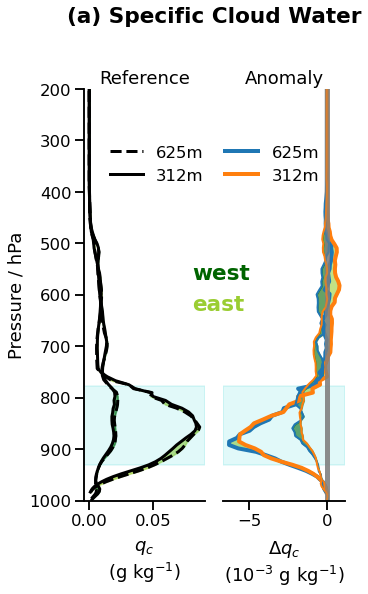

In [16]:
vname = 'qc.TL1'
unit = r'g kg${}^{-1}$'
var1 =  r'$q_c$'
var2 =  r'$\Delta q_c$'
ascale_factor = 1e3

xlabel1 = f'{var1}\n({unit})'
xlabel2 = f'{var2}\n(%s {unit})' % r'$10^{-3}$'

scale = 1e3
title = '(a) Specific Cloud Water'

plot_flux_ref_comparision(d, d, vname, xlabel1, xlabel2, title, scale, 
                          ascale_factor = ascale_factor,
                          xticks = [-5, 0],
                          plot_legend = True,
                          legend_position = (0.45, 0.5))


# more legends
fig = plt.gcf()
axs = fig.axes
axs[0].legend(loc = 'upper center', bbox_to_anchor = (0.6, 0.9), frameon = False)
axs[1].legend(loc = 'upper center', bbox_to_anchor = (0.4, 0.9), frameon = False)

plt.savefig( '../pics/west-east_qc.png', dpi = 300)

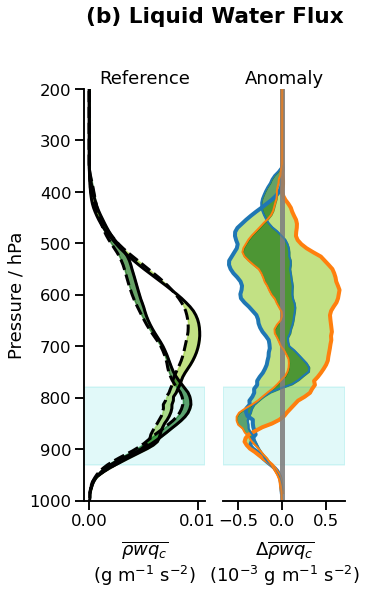

In [17]:
vname = 'rho_w_qc'
scale = 1e3
unit = r'g m${}^{-1}$ s${}^{-2}$'
var1 =  r'$\overline{\rho w q_c}$'
var2 =  r'$\Delta\overline{\rho w q_c}$'
ascale_factor = 1e3

xlabel1 = f'{var1}\n({unit})'
xlabel2 = f'{var2}\n(%s {unit})' % r'$10^{-3}$'

title = '(b) Liquid Water Flux'

plot_flux_ref_comparision(f, f, vname, xlabel1, xlabel2, title, scale, 
                          ascale_factor = ascale_factor,
                          xticks = [-0.5, 0, 0.5],
                          legend_position = (0.35, 0.7))

plt.savefig( '../pics/west-east_Fqc.png', dpi = 300)


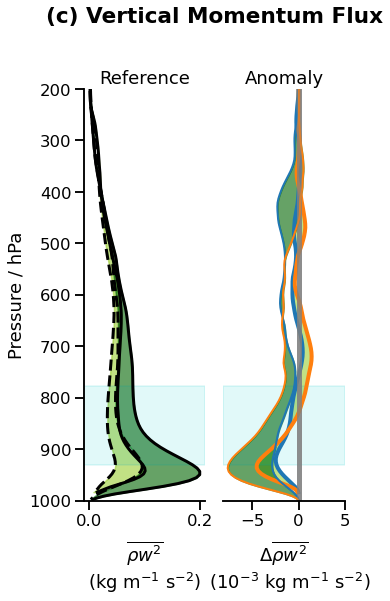

In [18]:
vname = 'rho_w_w'
unit = r'kg m${}^{-1}$ s${}^{-2}$'
var1 =  r'$\overline{\rho w^2}$'
var2 =  r'$\Delta\overline{\rho w^2}$'

title = '(c) Vertical Momentum Flux'
scale = 1.
ascale_factor = 1e3

xlabel1 = f'{var1}\n({unit})'
xlabel2 = f'{var2}\n  (%s {unit})' % r'$10^{-3}$'

plot_flux_ref_comparision(f, f, vname, xlabel1, xlabel2, title, scale , 
                          ascale_factor = ascale_factor,
                          xticks = [-5, 0, 5],
                          legend_position = (0.35, 0.6))

plt.savefig( '../pics/west-east_Fw.png', dpi = 300)